In [11]:
# Import required libraries
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate, LeaveOneOut
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
# import recmetrics as recmetrics ---> https://morioh.com/p/7208a4c1946d

import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

Note that in this example, we define a custom similarity measure user_similarity_with_features that takes in the user IDs and two dictionaries age_dict and sex_dict that map user IDs to their age and sex, respectively. The function computes a similarity score based on the difference in age and similarity in sex between the two users. The sim_options parameter is used to pass in these dictionaries and the custom similarity measure to the KNNWithMeans algorithm.

Also note that in the cross_validate method, we set measures=['RMSE'] to evaluate the algorithm using RMSE as the evaluation metric. You can add additional evaluation metrics such as MAE, precision, and recall by adding them to the measures list.

In [12]:
# https://github.com/NicolasHug/Surprise/issues/20 - see raw_ratings!!
class CustomDataset(Dataset):
    def __init__(self, df, reader):
        self.df = df
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['deputado_enc'], df['idVotacao'], df['vote_enc'])]
        self.reader = reader
    ## length of the dataset
    def __len__(self):
        return len(self.df)
        
    ## specific row from and includes the user characteristics as additional information in the form of a dictionary
    def __getitem__(self, index):
        deputado_enc, idVotacao, vote_enc, idade, gender_enc = self.df.iloc[index]
        return deputado_enc, idVotacao, vote_enc, {'idade':idade, 'gender_enc':gender_enc}
    
    def get_user_characteristics(self, deputado_enc):
        return self.df[self.df['deputado_enc'] == deputado_enc].iloc[0]['idade'], self.df[self.df['deputado_enc'] == deputado_enc].iloc[0]['gender_enc']

In [13]:
def evaluate_algorithms(trainset, testset, algorithms):
    """
    Evaluate a list of algorithms on a given dataset using a train/test split.
    """
    # Initialize dictionary to store results
    results = {}
    
    # Iterate over all algorithms
    for algorithm in algorithms:
        # Train the algorithm on the training set
        algorithm.fit(trainset)
            
        # Test the algorithm on the test set
        predictions = algorithm.test(testset)

        # Calculate evaluation metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        # Store results in dictionary
        results[algorithm.__class__.__name__]  = {
            'test_rmse': rmse,
            'test_mae': mae,
        }
    
    # Convert dictionary to DataFrame and sort by RMSE
    results = pd.DataFrame.from_dict(results, orient='index')
    results = results.sort_values('test_rmse')
    
    return results

def evaluate_algorithms_binary(trainset, testset, algorithms):
    """
    Evaluate a list of algorithms on a given dataset using a train/test split with binary ratings.
    """
    # Initialize dictionary to store results
    results = {}
    
    # Iterate over all algorithms
    for algorithm in algorithms:
        # Train the algorithm on the training set
        algorithm.fit(trainset)
            
        # Test the algorithm on the test set
        predictions = algorithm.test(testset)
        
         # Calculate evaluation metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Convert the predicted ratings to binary values (0 or 1)
        binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
        binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]
    
        # Calculate evaluation metrics
        acc = accuracy_score(binary_true_ratings, binary_predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')
        
        # Generate the confusion matrix
        tn, fp, fn, tp = confusion_matrix(binary_true_ratings, binary_predictions).ravel()
        matrix = pd.DataFrame({'Actual 0': [tn, fn], 'Actual 1': [fp, tp]}, index=['Predicted 0', 'Predicted 1'])
        
        # Store results in dictionary
        results[algorithm.__class__.__name__] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'test_rmse': rmse,
            'test_mae': mae,
        }
    
    # Convert dictionary to DataFrame and sort by F1 score
    results = pd.DataFrame.from_dict(results, orient='index')
    # matrix = pd.DataFrame.from_dict(matrix, orient="index")
    results = results.sort_values('f1_score', ascending=False)
    
    return results,matrix

In [14]:
def knnModel2(k, trainset, testset):
    # Train a KNN model
    model_knn = KNNBasic(k=k, sim_options={'name': 'pearson_baseline', 'user_based': False})
    model_knn.fit(trainset)
    predictions = model_knn.test(testset)
    rmse = accuracy.rmse(predictions)
    acc = accuracy.mae(predictions)
    return rmse, acc

def plot_knn_results(trainset, testset, k_values):
    """
    train and evaluate a KNN model for each k value in k_values, and plot the RMSE and MAE values
    """
    results = pd.DataFrame(columns=['k', 'rmse', 'accuracy'])
    for k in k_values:
        rmse, acc = knnModel2(k, trainset, testset)
        results = results.append({'k': k, 'rmse': rmse, 'accuracy': acc}, ignore_index=True)

    ##Plot the RMSE and MAE values for each k
    plt.plot(results['k'], results['rmse'], label='RMSE')
    plt.plot(results['k'], results['accuracy'], label='MAE')
    plt.xlabel('K')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()
    return results 

def bslModel(trainset):
    ## utilizes users past rating + general rating for a certain item 
    bsl_options = {'method': 'sgd',
                   'learning_rate': .00005,
                   'n_epochs': 20,
                   'reg': 0.1,
                   'reg_u': 0.2,
                   'reg_i': 0.2,
                   'verbose': False}

    model = BaselineOnly(bsl_options = bsl_options)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return rmse

def svdModel(trainset):
     # Train an SVD model
    model_svd = SVD(n_factors=100, biased=True, verbose=False)
    model_svd.fit(trainset)
    
    # Evaluate the model using accuracy, precision, recall, and F1 score metrics
    testset = trainset.build_anti_testset()
    predictions = model_svd.test(testset)
    acc = accuracy.mae(predictions)
    
    # Calculate the evaluation metrics
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    return rmse, mae

def svdModel_binary(trainset):
    # Train an SVD model
    model_svd = SVD(n_factors=100, biased=True, verbose=False)
    model_svd.fit(trainset)
    
    # Evaluate the model using accuracy, precision, recall, and F1 score metrics
    testset = trainset.build_anti_testset()
    predictions = model_svd.test(testset)
    
    # Convert the predicted ratings to binary values (0 or 1)
    binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
    binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]
    
    # Calculate the evaluation metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')

    print(precision, recall, f1_score)

In [15]:
##### DIFERENT TEST SIZES/K_VALUES FOR SVD AND KNN
def evaluate_test_size(data, test_sizes, k_values):
    # Create lists to store RMSE and MAE values for each test size and k value
    results = []

    # Iterate through each test size
    for test_size in test_sizes:
        # Split the data into a training set and a test set
        trainset, testset = train_test_split(data, test_size=test_size, random_state=42)

        for k in k_values:
            # Model 
            algo = KNNBaseline(k=k)
            algo.fit(trainset)
            
            predictions = algo.test(testset)
            
            # Convert the predicted ratings to binary values (0 or 1)
            binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
            binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]

            # Calculate evaluation metrics
            acc = accuracy_score(binary_true_ratings, binary_predictions)
            precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')

            result = {'Test Size': test_size, 'K': k, 'accuracy': acc, 'precision': precision, 'recall':recall, 'f1_score':f1_score}
            results.append(result)

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Return the results DataFrame
    return results_df

def test_SVD(data, test_sizes):   
    
    # Define the SVD model
    model = SVD()
    
    # Define the list to store the results
    results = []

    # Iterate over the test sizes and test the model
    for test_size in test_sizes:
#         start = datetime.datetime.now()

        # Split the data into a training set and a test set
        trainset, testset = train_test_split(data, test_size=test_size, random_state=42)
        
        model.fit(trainset)
            
        predictions = model.test(testset)

        #RMSE and MAE scores
        rmse = np.sqrt(np.mean([(pred.r_ui - pred.est)**2 for pred in predictions]))
        mae = np.mean([abs(pred.r_ui - pred.est) for pred in predictions])
#         cv_time = str(datetime.datetime.now() - start)[:-3]

        # Create a dictionary with the test size, RMSE, MAE, training time, and any other metrics
        result = {'Test Size': test_size, 'RMSE': rmse, 'MAE': mae}
        
        # Append the dictionary to the results list
        results.append(result)
        
    # Convert the results list to a DataFrame
    results = pd.DataFrame(results)

    return results

In [16]:
# Load the data into a pandas dataframe
dfP = pd.read_csv('..\data\preprocessed\dataVoting.csv')
dfP

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,4
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,4
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,2
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,4
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,2


In [17]:
data = dfP['vote_enc'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / dfP.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} vote-ratings'.format(dfP.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# With ALL votes - Continuous Rating (0-4)

In [18]:
# Create the reader
reader = Reader(rating_scale=(0, 4))
# Load the data into a dataset
data = Dataset.load_from_df(dfP[['deputado_enc', 'idVotacao', 'vote_enc']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [19]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  368 

Number of items:  472 



##### KNN MODEL - ratings 0-4, with previous voting 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5494
MAE:  0.1507
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.1928
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5133
MAE:  0.2185
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5728
MAE:  0.2950


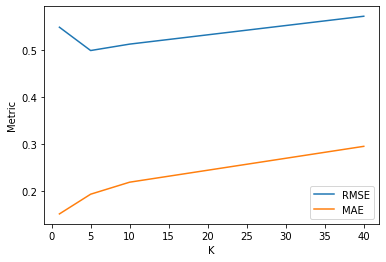

In [20]:
k_values = [1,5,10,40]
results_A = plot_knn_results(trainset,testset, k_values)

##### ALL Algorithms - ratings 0-4, with previous voting 

In [21]:
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results = evaluate_algorithms(trainset,testset, algorithms)

RMSE: 0.4554
MAE:  0.2512
RMSE: 0.7582
MAE:  0.5794
RMSE: 0.5007
MAE:  0.2815
RMSE: 1.3026
MAE:  1.0536
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4930
MAE:  0.2131
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4938
MAE:  0.2213
Estimating biases using als...
RMSE: 0.7583
MAE:  0.5919
RMSE: 0.5263
MAE:  0.2957


In [22]:
results

,test_rmse,test_mae
SVD,0.455354,0.251204
KNNBaseline,0.492954,0.213148
KNNWithMeans,0.493783,0.221341
NMF,0.500664,0.281514
CoClustering,0.526313,0.295740
SlopeOne,0.758160,0.579384
BaselineOnly,0.758258,0.591858
NormalPredictor,1.302568,1.053583


# With only Sim or Nao votes - Binary Rating

In [23]:
## create a new dataframe with only the yes or no votes
df_bool = dfP.loc[(dfP["vote_enc"] == 2) | (dfP["vote_enc"] == 4)] 

In [24]:
## replace values for 2 and 4 to 0 and 1
df_bool["vote_enc"].replace({2: 0, 4: 1}, inplace=True)

c:\Users\ritac\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
df_bool

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


In [26]:
data = df_bool['vote_enc'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df_bool.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} vote-ratings'.format(df_bool.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [27]:
# Create the reader
reader = Reader(rating_scale=(0, 1))
# Load the data into a dataset
data = Dataset.load_from_df(df_bool[['deputado_enc', 'idVotacao', 'vote_enc']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

### All Algorithms - Binary Ratings

### Basic algorithms
NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. 

BaselineOnly algorithm predicts the baseline estimate for given user and item. Memory-based algorithm that predicts ratings based on user and item biases only.

### k-NN algorithms
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user. Memory-based algorithm that uses a baseline estimate to account for user and item biases

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating. Memory-based algorithm that uses mean ratings instead of a baseline estimate to account for biases.

### Matrix Factorization-based algorithms
SVD
SVD algorithm is equivalent to Probabilistic Matrix Factorization. Model-based algorithm that factorizes the user-item matrix into two lower-dimensional matrices that represent user and item latent factors.

NMF
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD. Model-based algorithm that factorizes the user-item matrix into two non-negative lower-dimensional matrices that represent user and item latent factors

Slope One
SlopeOne is a straightforward implementation of the SlopeOne algorithm - Memory-based algorithm that uses the deviations between item ratings to predict ratings

Co-clustering
Coclustering is a collaborative filtering algorithm based on co-clustering. Model-based algorithm that clusters both users and items simultaneously to group similar ones together.

In [28]:
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results,matrix = evaluate_algorithms_binary(trainset,testset, algorithms)

RMSE: 0.2433
MAE:  0.1442
RMSE: 0.3731
MAE:  0.2808
RMSE: 0.2580
MAE:  0.1817
RMSE: 0.6106
MAE:  0.4935
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2423
MAE:  0.1035
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2424
MAE:  0.1068
Estimating biases using als...
RMSE: 0.3748
MAE:  0.2908
RMSE: 0.2546
MAE:  0.1362


In [29]:
results

,accuracy,precision,recall,f1_score,test_rmse,test_mae
KNNBaseline,0.924405,0.936416,0.928277,0.932329,0.242259,0.103548
KNNWithMeans,0.923972,0.935913,0.928020,0.931950,0.242426,0.106797
SVD,0.923827,0.934936,0.928857,0.931886,0.243304,0.144205
NMF,0.921949,0.939575,0.920036,0.929703,0.258004,0.181674
CoClustering,0.918626,0.929435,0.925187,0.927306,0.254554,0.136193
BaselineOnly,0.811681,0.831300,0.833441,0.832369,0.374843,0.290765
SlopeOne,0.811753,0.832089,0.832411,0.832250,0.373140,0.280799
NormalPredictor,0.507422,0.562451,0.549124,0.555708,0.610619,0.493533


In [14]:
# Plot the confusion matrix as a heatmap
# sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
# matrix

#### KNN with diferent K and test_sizes

In [30]:
# Define the test sizes to evaluate
test_sizes = np.arange(10, 91, 20)
k_values = [1,5,10,20,40]

# Evaluate the test sizes and store the results
results = evaluate_test_size(data, test_sizes,k_values)
results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

,Test Size,K,accuracy,precision,recall,f1_score
0,10,1,0.800000,0.833333,0.833333,0.833333
1,10,5,1.000000,1.000000,1.000000,1.000000
2,10,10,1.000000,1.000000,1.000000,1.000000
3,10,20,1.000000,1.000000,1.000000,1.000000
4,10,40,1.000000,1.000000,1.000000,1.000000
5,30,1,0.933333,0.947368,0.947368,0.947368
6,30,5,0.933333,0.904762,1.000000,0.950000
7,30,10,0.933333,0.904762,1.000000,0.950000
8,30,20,0.966667,0.950000,1.000000,0.974359
9,30,40,0.966667,0.950000,1.000000,0.974359


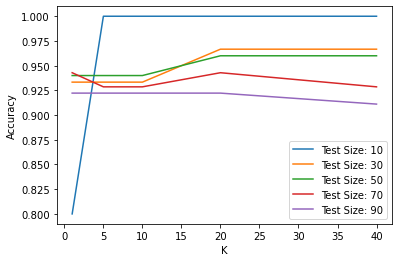

In [31]:
# Group the results by test size
grouped = results.groupby(['Test Size'])

# Iterate through each group and plot the RMSE values against k
for name, group in grouped:
    test_size = name
    plt.plot(group['K'], group['accuracy'], label=f"Test Size: {test_size}")

# Add axis labels and a legend
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

#### Noisy Data - 10% of real data

In [32]:
# add noise to ratings column
num_rows = len(df_bool)
num_real_ratings = int(num_rows * 0.1)  # keep 10% real ratings
num_noise_ratings = num_rows - num_real_ratings
noise_ratings = np.random.randint(2, size=num_noise_ratings)  # generate random binary ratings
ratings = np.concatenate((df_bool['vote_enc'].values[:num_real_ratings], noise_ratings))  # combine real and noise ratings
np.random.shuffle(ratings)  # shuffle the ratings
df_bool['vote_noise'] = ratings  # replace the original ratings with the shuffled ratings

C:\Users\ritac\AppData\Local\Temp/ipykernel_16944/3285990240.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# Load the data into a dataset
data = Dataset.load_from_df(df_bool[['deputado_enc', 'idVotacao', 'vote_noise']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [34]:
# Define the test sizes to evaluate
test_sizes = np.arange(10, 91, 20)
k_values = [1,5,10,20,40]

# Evaluate the test sizes and store the results
results = evaluate_test_size(data, test_sizes,k_values)
results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

,Test Size,K,accuracy,precision,recall,f1_score
0,10,1,0.500000,0.428571,0.750000,0.545455
1,10,5,0.500000,0.400000,0.500000,0.444444
2,10,10,0.700000,0.571429,1.000000,0.727273
3,10,20,0.500000,0.400000,0.500000,0.444444
4,10,40,0.800000,0.750000,0.750000,0.750000
5,30,1,0.533333,0.473684,0.692308,0.562500
6,30,5,0.566667,0.500000,0.692308,0.580645
7,30,10,0.500000,0.458333,0.846154,0.594595
8,30,20,0.466667,0.434783,0.769231,0.555556
9,30,40,0.533333,0.476190,0.769231,0.588235


In [35]:
# Split the data into training and testing sets
trainset = data.build_full_trainset()
# 10% data for test
test_size = int(len(df_bool) * 0.1)
# 5% deputies
test_deputies = df_bool['deputado_enc'].unique()[:int(len(df_bool['deputado_enc'].unique())*0.05)] 

In [36]:
testset = []
for deputado_enc in test_deputies:
    deputy_votes = df_bool[df_bool['deputado_enc'] == deputado_enc]
    # index split the data into training and test sets
    split_index = int(len(deputy_votes) * 0.9)
    test_ratings = deputy_votes.iloc[split_index:].itertuples(index=False)
    testset += [(str(r.deputado_enc), str(r.idVotacao), r.vote_enc) for r in test_ratings]

# Print the size of the training and testing sets
print('Number of deputies in the training set: ', trainset.n_users)
print('Number of votes in the training set: ', trainset.n_items)
print('Number of deputies in the testing set: ', len(test_deputies))
print('Number of votesin the testing set: ', len(testset))

Number of deputies in the training set:  368
Number of votes in the training set:  473
Number of deputies in the testing set:  18
Number of votesin the testing set:  572


In [37]:
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results,matrix = evaluate_algorithms_binary(trainset,testset, algorithms)

RMSE: 0.5031
MAE:  0.5018
RMSE: 0.4994
MAE:  0.4994
RMSE: 0.4994
MAE:  0.4994
RMSE: 0.6024
MAE:  0.4932
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5025
MAE:  0.5014
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994
Estimating biases using als...
RMSE: 0.5025
MAE:  0.5014
RMSE: 0.4994
MAE:  0.4994


In [38]:
results

,accuracy,precision,recall,f1_score,test_rmse,test_mae
SlopeOne,0.578671,0.578671,1.000000,0.733112,0.499409,0.499395
NMF,0.578671,0.578671,1.000000,0.733112,0.499409,0.499395
KNNWithMeans,0.578671,0.578671,1.000000,0.733112,0.499409,0.499395
CoClustering,0.578671,0.578671,1.000000,0.733112,0.499409,0.499395
SVD,0.494755,0.568182,0.528701,0.547731,0.503139,0.501754
NormalPredictor,0.489510,0.568421,0.489426,0.525974,0.602447,0.493247
KNNBaseline,0.479021,0.561338,0.456193,0.503333,0.502533,0.501407
BaselineOnly,0.479021,0.561338,0.456193,0.503333,0.502533,0.501407


### Knn, with k = [1,5,10,20,40]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4994
MAE:  0.4994


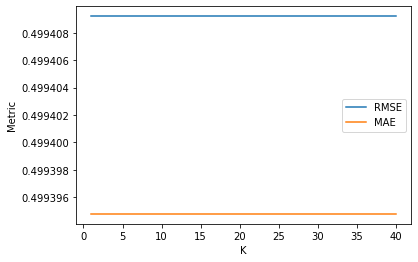

In [39]:
k_values = [1,5,10,20,40]
results_YN = plot_knn_results(trainset,testset, k_values)

In [40]:
svdModel_binary(trainset)

1.0 0.5068703013456315 0.6727457577377397


In [41]:
bslModel(trainset)

Estimating biases using sgd...
RMSE: 0.5000


0.5000435888658187

# With orientation, gender, age and city - Continuous Rating

In [125]:
# Convert the data into a Surprise-compatible dataset format
reader = Reader(rating_scale=(0, 4))
data_spec = CustomDataset(dfP, reader)

In [126]:
# Split the data into a training set and a test set
trainset, testset = train_test_split(data_spec, test_size=0.25, random_state=42)

In [127]:
bslModel(trainset)

Estimating biases using sgd...
RMSE: 0.9254


0.9254046321986652

In [128]:
svdModel(trainset)

MAE:  0.7370
RMSE: 0.7915
MAE:  0.7370


(0.791548838752148, 0.7369818420275982)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5494
MAE:  0.1507
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4996
MAE:  0.1928
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5133
MAE:  0.2185
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5413
MAE:  0.2535
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5728
MAE:  0.2950


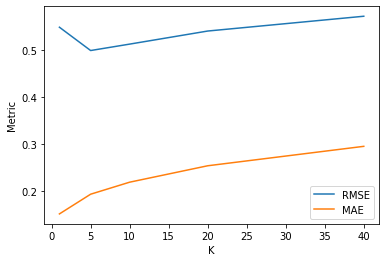

,k,rmse,accuracy
0,1.0,0.549409,0.150711
1,5.0,0.499628,0.192813
2,10.0,0.513332,0.218479
3,20.0,0.541256,0.253531
4,40.0,0.572848,0.295029


In [129]:
k_values = [1,5,10,20,40]
plot_knn_results(trainset,testset, k_values)